In [1]:
import pandas as pd
from glob import glob
import json
import matplotlib.pyplot as plt

In [2]:
files = glob("*.json")
df = None

for f in files:
  f_data = json.load(open(f))
  series = pd.Series()

  model, degree, _, _ = f.split(".")
  series["degree"] = int(degree) + 1
  series["model"] = model

  #series["train_losses"] = f_data["train_losses"]
  #series["train_loss"] = f_data["train_losses"][-1] if len(series["train_losses"]) > 0 else -1

  #series["test_losses"] = f_data["test_losses"]
  #series["test_loss"] = f_data["test_losses"][-1] if len(series["test_losses"]) > 0 else -1

  for rel, val in f_data["relationship_weights"].items():
    series[rel] = val

  metrics = {k: [m[k] for m in f_data["metrics"]] for k in f_data["metrics"][0].keys()}
  #series["metrics"] = metrics

  for k, v in metrics.items():
    series[k] = v[-1]

  series = series.to_frame().T
  if df is None:
    df = series
  else:
    df = pd.concat([df, series])

df.columns = [c.replace("@None", "") for c in df.columns]

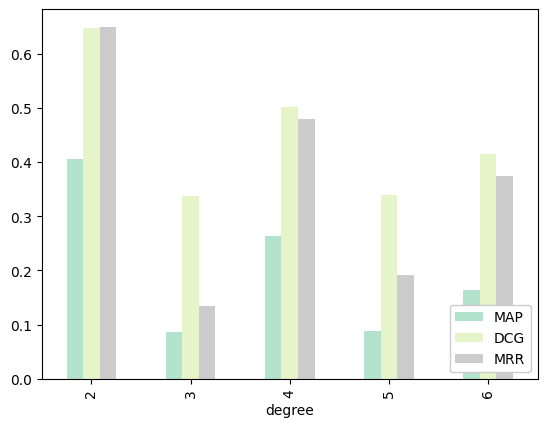

In [3]:
ax = df.groupby(["degree"])[["MAP", "DCG", "MRR"]].mean().plot.bar(cmap="Pastel2")
ax.legend(loc='lower right', framealpha=1)
fig = ax.get_figure()
fig.savefig('degree-plot.png', dpi=300)

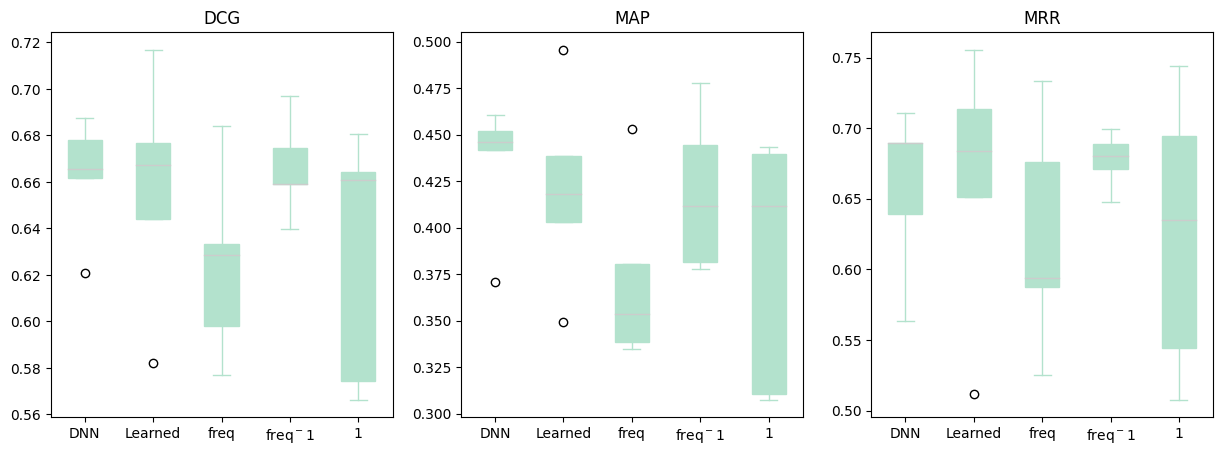

In [4]:
axs = df[df.degree == 2].plot.box(column=["MAP", "DCG", "MRR"], cmap="Pastel2", by="model", figsize=(15, 5), patch_artist=True)

for ax in axs:
  ax.set_xticklabels(["DNN", "Learned", "freq", "freq$^-1$", 1])


In [28]:
print(df.groupby("model")[["MAP", "DCG", "MRR"]].std().to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrr}
\toprule
 & MAP & DCG & MRR \\
model &  &  &  \\
\midrule
dnn & 0.17 & 0.19 & 0.26 \\
fit & 0.12 & 0.10 & 0.15 \\
frequency & 0.12 & 0.12 & 0.23 \\
inverse-frequency & 0.16 & 0.16 & 0.27 \\
uniform & 0.13 & 0.13 & 0.24 \\
\bottomrule
\end{tabular}



In [14]:
columns = [
  'http://w3id.org/friendshipneverends/ontology/isFriendOf',
  'http://w3id.org/friendshipneverends/ontology/hasAcquaintance',
  'http://w3id.org/friendshipneverends/ontology/hasPupil',
  'http://w3id.org/friendshipneverends/ontology/hasBandmate',
  'http://w3id.org/friendshipneverends/ontology/hasFriend',
  'http://w3id.org/friendshipneverends/ontology/hasMentor',
  'MRR',
  'MAP', 
  'DCG'
]

In [24]:
df[columns].corr().loc[["MRR", "MAP", "DCG"], columns[:-3]]

,http://w3id.org/friendshipneverends/ontology/isFriendOf,http://w3id.org/friendshipneverends/ontology/hasAcquaintance,http://w3id.org/friendshipneverends/ontology/hasPupil,http://w3id.org/friendshipneverends/ontology/hasBandmate,http://w3id.org/friendshipneverends/ontology/hasFriend,http://w3id.org/friendshipneverends/ontology/hasMentor
MRR,0.123149,0.238396,0.153732,0.240316,0.184555,0.120064
MAP,0.107046,0.312574,0.142421,0.251517,0.179805,0.103178
DCG,0.117468,0.278876,0.152953,0.246469,0.188005,0.114623


In [76]:
import numpy as np
small_df = df[(df.model == "fit") & (df.degree == 2)].groupby(["degree", "model"]).agg(["median", "mean", "min", "max"])[columns[:-3]].T.reset_index()
small_df.columns = small_df.columns.get_level_values(0)
small_df = small_df.pivot(columns="level_1", index="level_0", values=2)

In [84]:
print(small_df.to_latex())

\begin{tabular}{lllll}
\toprule
level_1 & max & mean & median & min \\
level_0 &  &  &  &  \\
\midrule
http://w3id.org/friendshipneverends/ontology/hasAcquaintance & 10.056623 & 9.803818 & 9.924235 & 9.455043 \\
http://w3id.org/friendshipneverends/ontology/hasBandmate & 15.026949 & 10.266096 & 8.583899 & 7.490868 \\
http://w3id.org/friendshipneverends/ontology/hasFriend & 16.666573 & 14.521490 & 15.862931 & 10.857057 \\
http://w3id.org/friendshipneverends/ontology/hasMentor & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
http://w3id.org/friendshipneverends/ontology/hasPupil & 17.717623 & 11.493589 & 12.150506 & 6.904581 \\
http://w3id.org/friendshipneverends/ontology/isFriendOf & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}

